In [1]:
import random

import torch
import numpy as np
from bindsnet.network import Network
from bindsnet.network.nodes import Input
from bindsnet.learning.learning import MSTDPET, PostPre, NoOp
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

from libs.learning import PostPreInh, MSTDPET_SEASONAL, MSTDP_SEASONAL, RSTDP_SEASONAL, AbstractSeasonalLearning
from libs.second_appr_simp_t2 import CorticalColumn, LayerConnection, ComplexStructure, LAYER_23, LAYER_4
from libs.connections import ConnectionWithConvergence, RandomConnection, MaxPool1dConnection, get_output_size_maxpool1d

In [2]:
model_name = 'c2'
seed = random.randint(0,9999999)
print(seed)

5533728


In [3]:
# seed = 1400
random.seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

In [4]:
input_size = 200
each_session = 30
session_number = 2000
layer23_involve_from = 500
gap_time = 20

time = session_number * each_session
spike_train = torch.zeros(time, input_size).bool()
timestep_class = torch.zeros(time).bool()

session_class = torch.rand(session_number) < 0.5
# session_class = torch.tensor(([True, False] * int((session_number + 1) / 2))[:session_number])

active_fire_rate = 0.2
pattern_size = int(input_size/2)

for idx, cls in enumerate(session_class):
    passive_noise = torch.rand(each_session, input_size) < 0.01 + (random.random() * 0.01 - 0.005)
    spike_train[idx * each_session: (idx + 1) * each_session, :] = passive_noise
    if cls:
        pattern_1 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_1[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, :int(input_size/2)] |= pattern_1
    else:
        pattern_2 = torch.rand(each_session, pattern_size) < active_fire_rate
        pattern_2[each_session - gap_time:, :] = 0
        spike_train[idx * each_session: (idx + 1) * each_session, int(input_size/2):] |= pattern_2
    
    timestep_class[idx * each_session: (idx + 1) * each_session] = cls

In [5]:
spike_train.T[:, 100:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False,  True,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True]])

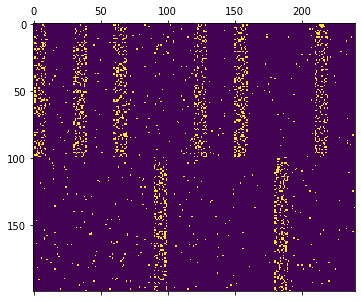

In [6]:
import matplotlib.pyplot as plt

plt.matshow(spike_train.T[:, :8 * each_session])

In [7]:
connection_args = { # Between Layer
    'kernel_size': 5,
    'stride': 3
}
layer_args_l23 = {
    'exc_size': get_output_size_maxpool1d(100, 5, 3),
    'inh_con_args': { # Inside Layer
        'wmin': -1.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 1.0,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 10,
        'traces': True,
        'tc_decay': 10,
        'refrac': 10,
    }
}
layer_args_l4 = {
    'exc_size': 100,
    'inh_con_args': { # Inside Layer
        'wmin': -0.5,
        'wmax': 0,
        'update_rule': NoOp,
        'probability': 0.30,
    },
    'exc_args': {
        'thresh': -52.0,
        'tc_trace': 6,
        'traces': True,
        'tc_decay': 10,
        'refrac': 10,
#         'rest':-57
    }
}
connection_type = RandomConnection

In [8]:
input_pop_c1 = Input(input_size, traces=True, tc_trace=6)
input_name = f'input_{model_name}'
c1 = CorticalColumn(connection_args, layer_args_l23, layer_args_l4, name=model_name, monitor=LAYER_23|LAYER_4)
input_to_c1_connection = LayerConnection((input_name, input_pop_c1), c1, connection_type, {
    'wmin': 0.,
    'wmax': 0.8,
    'nu': [0.02, 0.01],
#     'update_rule': PostPre,
    'probability': 0.30,
    
    'update_rule': MSTDPET_SEASONAL,
    'tc_plus': 6,
    'tc_minus': 6, 
    'tc_e_trace': 6,
})

In [9]:
c1_with_input = ComplexStructure()
c1_with_input.add_pop(input_name, input_pop_c1)
c1_with_input.add_submodule(c1)
c1_with_input.add_submodule(input_to_c1_connection)
c1_with_input.add_outpops(c1.get_output_pops())

In [10]:
network = Network(dt=1.0)
c1_with_input.add_to_network(network)

bl_monitors = []
bl_monitors_name = []
for a, b, con in input_to_c1_connection.connections:
    tmp = Monitor(obj=con, state_vars=['converge'])
    network.add_monitor(monitor=tmp, name=f"{a}_{b}_connection_monitor")
    bl_monitors.append(tmp)
    bl_monitors_name.append((a, b))
    

In [11]:
# Disable layer 2,3
# c1.l23.disable_learning()
# c1.l4_l23.disable_learning()

In [12]:
from tqdm import trange

rewards = []
changes = []
activities = []
# inputs = {'input_c1' : spike_train}
for part in trange(session_number, unit="parts"):
# for part in trange(1, unit="parts"):

#     if part == layer23_involve_from:
#         c1.l4.disable_learning()
#         input_to_c1_connection.disable_learning()
        
#         c1.l23.enable_learning()
#         c1.l4_l23.enable_learning()
        
        
    inp = {input_name: spike_train[part*each_session:part*each_session+each_session, :]}
    network.run(inputs=inp, time=each_session)
    
    avg_sessions = 10
    in_use_sessions = min(part + 1, avg_sessions)
    exc1_avg = c1.l23.monitors[0][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    exc2_avg = c1.l23.monitors[1][1].get('s')[-each_session * in_use_sessions:,0,:].sum() / in_use_sessions
    
    exc1_act = c1.l23.monitors[0][1].get('s')[-each_session:,0,:].sum()# - exc1_avg
    exc2_act = c1.l23.monitors[1][1].get('s')[-each_session:,0,:].sum()# - exc2_avg
    
    activities.append((exc1_act, exc2_act))
    
    pattern = session_class[part]
    gap = abs(exc2_act - exc1_act) / layer_args_l23['exc_size']  #  In Range 0-1
    gap_check = abs(exc2_act - exc1_act) / layer_args_l23['exc_size'] > 0.3
    
    exc1_wins = exc1_act > exc2_act
    
    if pattern == exc1_wins and gap_check:
        reward = 1.0 + gap
    elif pattern == exc1_wins:
        reward = -0.1 + gap
    else:
        reward = -1 - gap
    
#     if pattern and exc1_act > 20 and exc2_act < 10:
#         reward = 1.0 + gap
#     elif not pattern and exc2_act > 20 and exc1_act < 10:
#         reward = 1.0 + gap
#     elif exc1_wins != pattern:
#         reward = -1 - gap
#     else:
#         reward = -0.1
        
    rewards.append(reward)
    
    for conn in input_to_c1_connection.connections:
        if isinstance(conn[2].update_rule, AbstractSeasonalLearning):
            change = conn[2].update_rule.trigger(reward)
            changes.append(change)
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [04:54<00:00,  6.79parts/s]


In [13]:
# c1.l23.disable_learning()
# c1.l4_l23.disable_learning

In [14]:
rewards[-300:]

[tensor(1.9375),
 tensor(1.8750),
 tensor(1.8125),
 tensor(1.9688),
 tensor(1.8750),
 tensor(1.7500),
 tensor(2.),
 tensor(1.8438),
 tensor(1.8438),
 tensor(1.7812),
 tensor(1.9688),
 tensor(1.7500),
 tensor(2.),
 tensor(1.9688),
 tensor(1.8438),
 tensor(1.8438),
 tensor(1.9688),
 tensor(1.8125),
 tensor(1.9688),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(1.6562),
 tensor(1.6875),
 tensor(1.8125),
 tensor(1.9062),
 tensor(1.9688),
 tensor(1.8750),
 tensor(1.9375),
 tensor(1.9688),
 tensor(1.7812),
 tensor(1.8438),
 tensor(1.9062),
 tensor(1.7812),
 tensor(1.9688),
 tensor(1.8438),
 tensor(2.),
 tensor(1.9688),
 tensor(1.9375),
 tensor(1.7500),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(1.8438),
 tensor(1.9375),
 tensor(2.),
 tensor(1.5625),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(1.6250),
 tensor(1.8125),
 tensor(1.8438),
 tensor(2.),
 tensor(2.),
 tensor(2.),
 tensor(1.8438),
 tensor(1.9375),
 tensor(1.8750),
 tensor(1

In [15]:
session_class[-300:]

tensor([False, False, False,  True, False, False,  True, False,  True, False,
         True, False,  True,  True, False, False, False,  True,  True,  True,
         True,  True, False, False,  True, False,  True, False, False,  True,
        False, False,  True, False, False,  True,  True, False,  True, False,
         True,  True,  True,  True,  True, False, False, False, False,  True,
         True,  True,  True,  True, False,  True,  True, False,  True,  True,
        False,  True, False, False, False, False, False, False,  True, False,
        False, False, False,  True, False,  True,  True,  True, False, False,
         True,  True, False, False,  True, False, False, False,  True,  True,
         True,  True,  True, False,  True,  True, False,  True, False, False,
        False, False,  True, False, False,  True,  True, False,  True, False,
        False, False,  True, False,  True,  True,  True,  True,  True,  True,
        False,  True,  True, False, False, False, False, False, 

In [16]:
# for i in range(100):
#     x = torch.linspace(-0.05, 0.05, steps=40)
#     plt.bar(x, torch.histc(changes[i], bins=40, min=-0.05, max=0.05), align='center', width=0.002)
#     plt.figure()

## Convergence

('input_c2', 'c2_l4__exc1')
('input_c2', 'c2_l4__exc2')


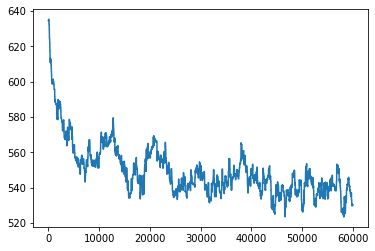

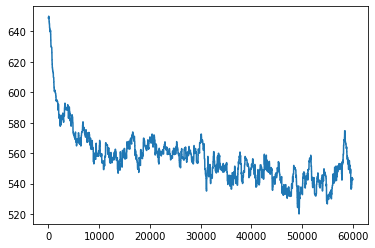

In [17]:
for name, m in zip(bl_monitors_name, bl_monitors):
    print(name)
    plt.figure()
    plt.plot(m.get('converge'))

In [18]:
# plt.plot(inp_2_c1_monitor_1.get('converge'))
# plt.figure()
# plt.plot(inp_2_c1_monitor_2.get('converge'))

In [19]:
time_show = time

In [20]:
spikes = {
    "L4 | 1": c1.l4.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L4 | 2": c1.l4.monitors[1][1].get('s')[-time_show:,0,:].T, 
    
    "L23 | 1": c1.l23.monitors[0][1].get('s')[-time_show:,0,:].T, 
    "L23 | 2": c1.l23.monitors[1][1].get('s')[-time_show:,0,:].T,
}

## Confusion

### Layer 4

In [21]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    100.0
L4 -- Excitatory 1 -- Pattern 2     :    8.962963104248047
L4 -- Excitatory 2 -- Pattern 1     :    1.91304349899292
L4 -- Excitatory 2 -- Pattern 2     :    99.96295928955078


In [22]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    100.0
L4 -- Excitatory 1 -- Pattern 2     :    9.11111068725586
L4 -- Excitatory 2 -- Pattern 1     :    1.6304347515106201
L4 -- Excitatory 2 -- Pattern 2     :    99.96295928955078


In [23]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L4 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L4 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L4 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L4 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    99.72386932373047
L4 -- Excitatory 1 -- Pattern 2     :    5.3935089111328125
L4 -- Excitatory 2 -- Pattern 1     :    2.9349112510681152
L4 -- Excitatory 2 -- Pattern 2     :    99.78397369384766


### Layer 2,3

In [24]:
print(f"L4 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -1500:][:, timestep_class[-1500:]].sum() / session_class[-50:].sum()}")
print(f"L4 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -1500:][:, ~ timestep_class[-1500:]].sum() / (~ session_class)[-50:].sum()}")

L4 -- Excitatory 1 -- Pattern 1     :    31.60869598388672
L4 -- Excitatory 1 -- Pattern 2     :    5.037036895751953
L4 -- Excitatory 2 -- Pattern 1     :    0.6086956262588501
L4 -- Excitatory 2 -- Pattern 2     :    31.629629135131836


In [25]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, -3000:][:, timestep_class[-3000:]].sum() / session_class[-100:].sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, -3000:][:, ~ timestep_class[-3000:]].sum() / (~ session_class)[-100:].sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    31.7391300201416
L23 -- Excitatory 1 -- Pattern 2     :    5.407407283782959
L23 -- Excitatory 2 -- Pattern 1     :    0.54347825050354
L23 -- Excitatory 2 -- Pattern 2     :    31.481481552124023


In [26]:
print(f"L23 -- Excitatory 1 -- Pattern 1     :    {spikes['L23 | 1'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 1 -- Pattern 2     :    {spikes['L23 | 1'][:, ~ timestep_class].sum() / (~ session_class).sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 1     :    {spikes['L23 | 2'][:, timestep_class].sum() / session_class.sum()}")
print(f"L23 -- Excitatory 2 -- Pattern 2     :    {spikes['L23 | 2'][:, ~ timestep_class].sum() / (~ session_class).sum()}")

L23 -- Excitatory 1 -- Pattern 1     :    31.633136749267578
L23 -- Excitatory 1 -- Pattern 2     :    2.813387393951416
L23 -- Excitatory 2 -- Pattern 1     :    1.2189348936080933
L23 -- Excitatory 2 -- Pattern 2     :    31.558822631835938


## Pattern Separation

In [27]:
for source, target, connection in input_to_c1_connection.connections:
    print(f"{source} (0:99)    --->   {target}   :   {connection.w[:100, :].sum()}")
    print(f"{source} (100:199) --->   {target}   :   {connection.w[100:, :].sum()}")

input_c2 (0:99)    --->   c2_l4__exc1   :   1575.94140625
input_c2 (100:199) --->   c2_l4__exc1   :   1263.030517578125
input_c2 (0:99)    --->   c2_l4__exc2   :   1136.555419921875
input_c2 (100:199) --->   c2_l4__exc2   :   1608.51611328125


In [28]:
# for source, target, connection in c1.l4_l23.connections:
#     print(f"{source}   --->   {target}   :   {connection.w.sum()}")

## Activities

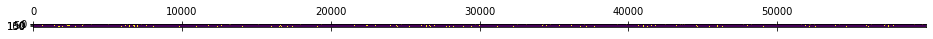

In [29]:
plt.matshow(spike_train.T[:, -time_show:])

In [30]:
c1.l4.monitors[0][1].get('s').shape

torch.Size([60000, 1, 100])

In [31]:
spikes["L4 | 1"].shape

torch.Size([100, 60000])

In [32]:
spikes["L4 | 1"].sum(0).shape[0]

60000

In [33]:
spikes["L4 | 1"][:,-150:]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [34]:
spikes["L4 | 1"][:,-300:-270].sum()

tensor(100)

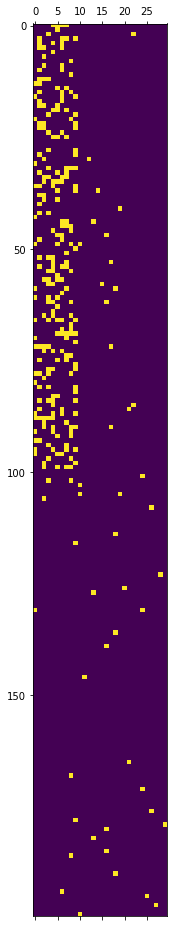

In [35]:
x = 499
plt.matshow(spike_train.T[:, x * each_session:x * each_session + each_session])

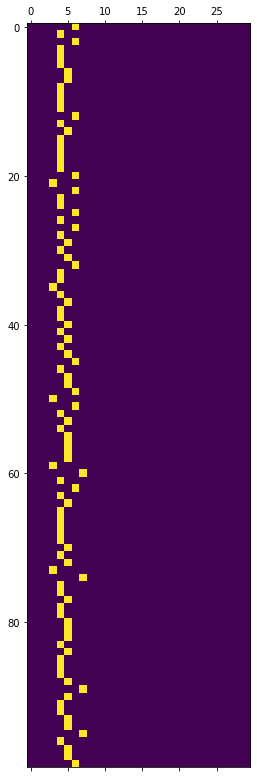

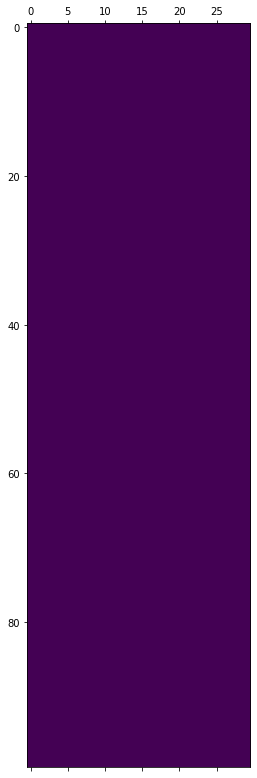

In [36]:
x = 999
plt.matshow(spikes["L4 | 1"][:, x * each_session:x * each_session + each_session])
plt.matshow(spikes["L4 | 2"][:, x * each_session:x * each_session + each_session])

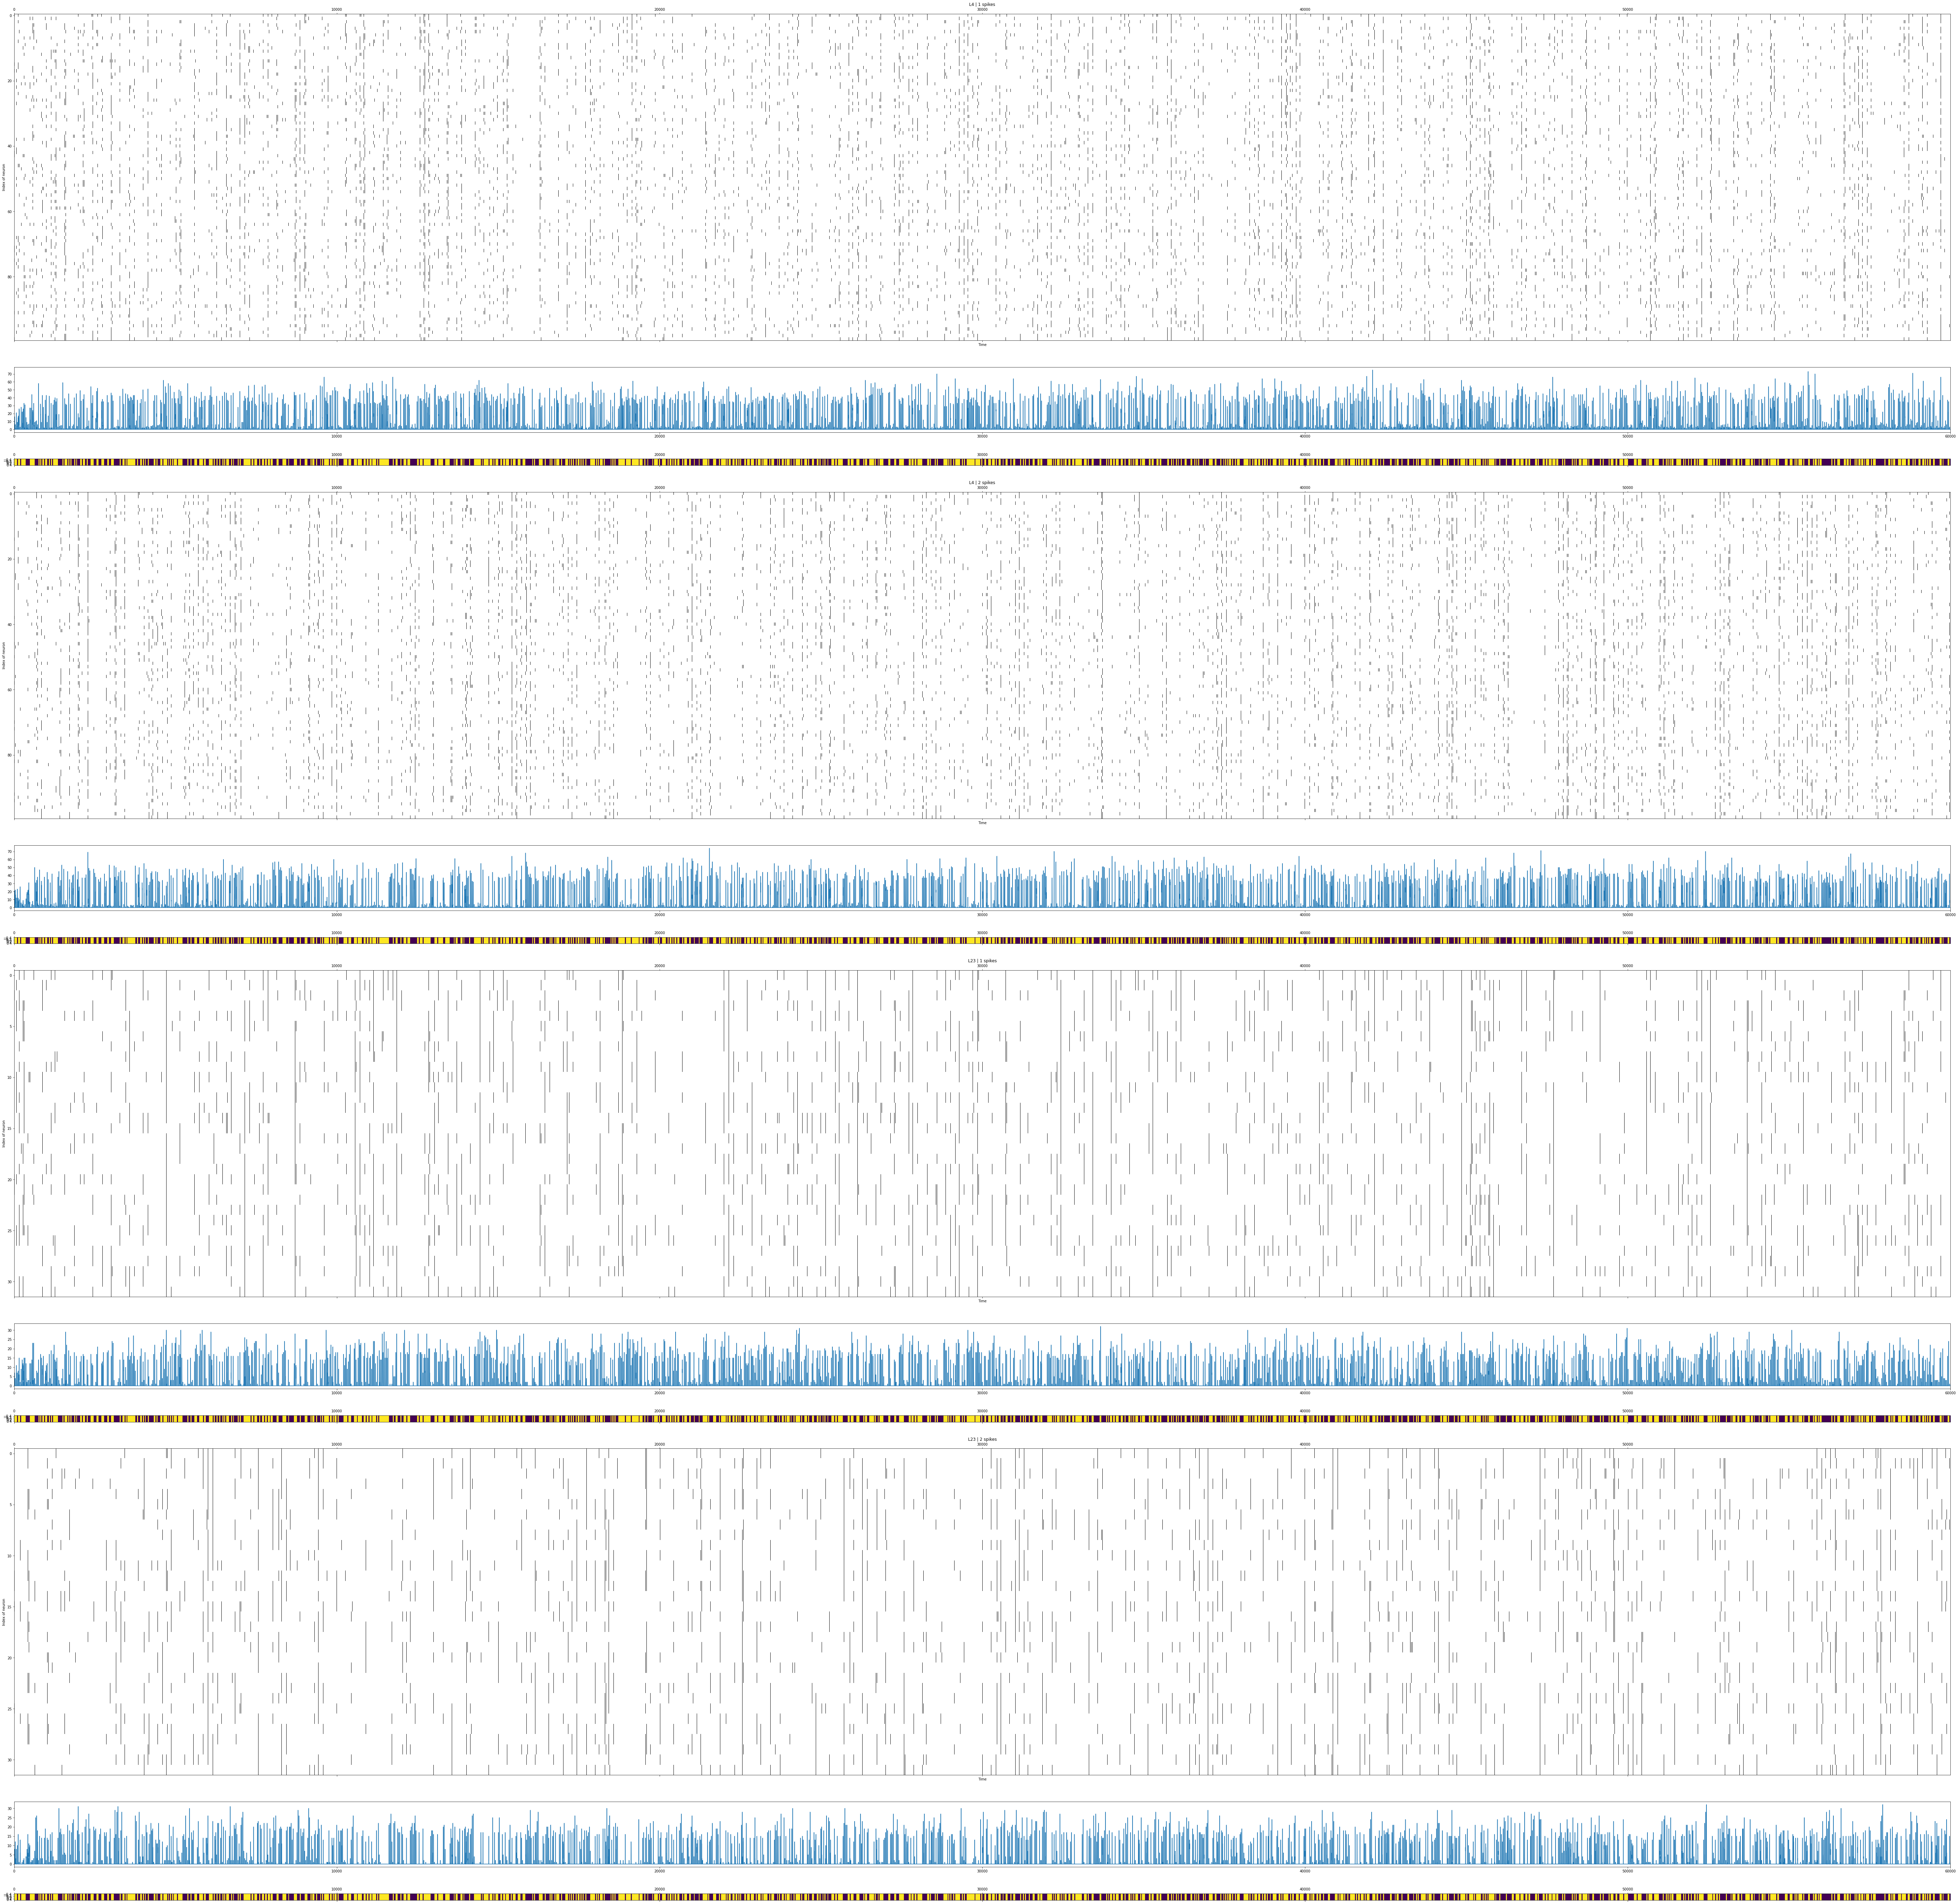

In [37]:
ver_num = len(spikes)
fig, axes = plt.subplots(ver_num * 3, 1, figsize=(100, 100), gridspec_kw={'height_ratios': [50, 10, 1] * ver_num})
# fig.suptitle(f"Spikes: t={start_time}-{end_time}")
for idx, layer in enumerate(spikes):
    indx = idx * 3
    axes[indx].matshow(spikes[layer], cmap='Greys')
    axes[indx].set_title('%s spikes' % layer)
    axes[indx].set_xlabel('Time')
    axes[indx].set_ylabel('Index of neuron')
    axes[indx].set_aspect('auto')
    
    activity = spikes[layer].sum(0)
    axes[indx + 1].plot(activity)
    axes[indx + 1].set_aspect('auto')
    axes[indx + 1].set_xlim([0, activity.shape[0]])
    
    axes[indx + 2].matshow(timestep_class[-time_show:].unsqueeze(1).T)
    axes[indx + 2].set_aspect('auto')

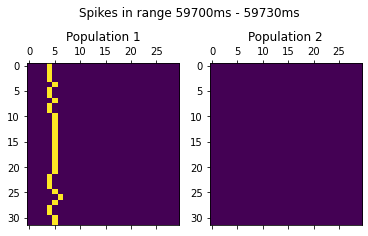

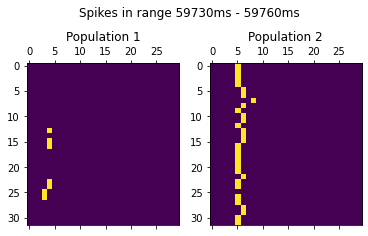

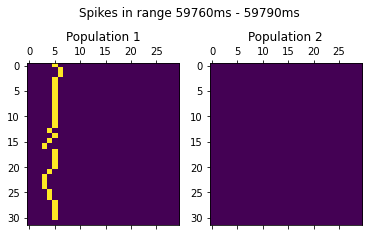

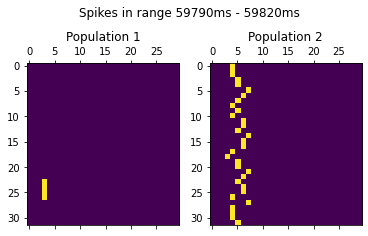

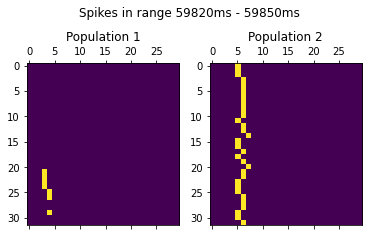

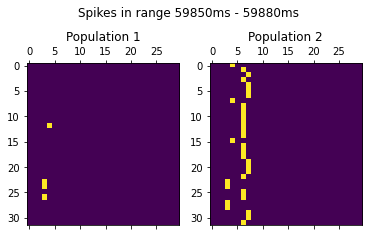

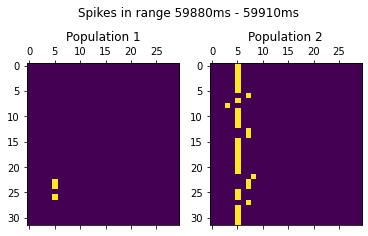

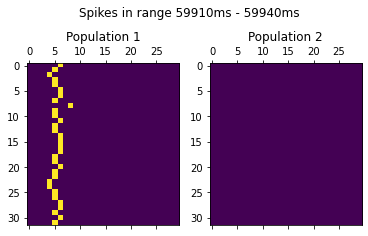

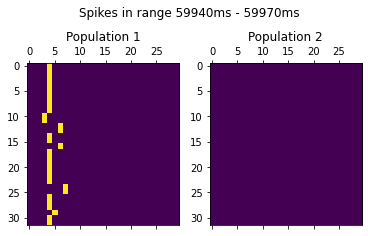

In [38]:
# x = 999
for x in range(1990, 1999):
    fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(session_class[x])
#     plt.matshow(timestep_class[x * each_session:x * each_session + each_session].unsqueeze(1).T)
    ax1.matshow(spikes["L23 | 1"][:, x * each_session:x * each_session + each_session])
    ax2.matshow(spikes["L23 | 2"][:, x * each_session:x * each_session + each_session])
    fig.suptitle(f'Spikes in range {x * each_session}ms - {x * each_session + each_session}ms')
    ax1.set_title("Population 1")
    ax2.set_title("Population 2")

# Save Model And Notebook

In [39]:
%%javascript
require(["base/js/namespace"],function(Jupyter) {
    Jupyter.notebook.save_checkpoint();
});
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [40]:
c1_with_input.save(f'models/{model_name}.pt')

["[NbConvertApp] WARNING | pattern '.\\\\\\\\{nb_name}' matched no files"]

In [41]:
!! jupyter-nbconvert --to html .\\{nb_name} --stdout > models/{model_name}.html

['[NbConvertApp] Converting notebook .\\\\c2-create-pooling.ipynb to html']